# Introduction

In this notebook we explore the effectiveness of 3 models in predicting patient survival. Specifically we examine : 

1. Logistic Regression
2. Decision Tree
3. Random Forest

# Introduction

In this notebook we explore the effectiveness of 3 models in predicting patient survival. Specifically we examine : 

1. Logistic Regression
2. Decision Tree
3. Random Forest

# Setup

## Data Ingestion

In [1]:
# Library Imports
import sqlite3 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV

import importlib
import helper as hp
import random


In [2]:
# Load in data
conn = sqlite3.connect("../datasets/ICU_data.sqlite")
df = pd.read_sql_query(\
"""
SELECT 
    *
FROM ICU_data
"""
, con=conn)
conn.close()

## Imbalanced Dataset

Note that the dataset is slightly imbalanced. The target class ratio is exactly <mark style='background-color: lightblue'> 4 : 1 </mark>, with the majority of patients surviving. 

In [3]:
(df.Survive.value_counts(normalize=True)*100).rename("Target Proportions")

1    80.0
0    20.0
Name: Target Proportions, dtype: float64

The <mark style='background-color: lightblue'>class imbalance is relatively slight at this ratio</mark>, so we may not necessarily need to account for this class imblance.

Depending on the model used we may also be able to handle this within the model itself. For exmaple with logistic regression we could assign a higher penalty to mistakes on the under-represented class. 

## Target recoding

This machine learning problem centers around predicting patient survival. In this case it is logical for us to focus __more__ on identifying patients that __do not survive__ so that more intervention could take place upon their arrival for better patient outcomes. 

With this in mind we can recode the target from `Survive` to `not_survive`, taking the reverse of the binary outcome for each recorded patient. This simplifies the performance assessment of each model later on as we pay special attention to predicting the class with target label == 1

In [4]:
# Target recording
df['not_survive'] = df['Survive'].apply(lambda x : 0 if x == 1 else 1)

## Non-Numeric Features

As mentioned previously, all non-numeric features (except for AgeGroup) are binary. This means we do not need to perform any encoding before using them as model inputs. 

## Train Test Split

Splitting the full dataset into the train and test set. 

__Note__ that we will not use `AgeGroup` as an input feature for the models, instead we will use `Age`

In [5]:
# Assign feature & target vectors
X, y = df[df.columns.difference(["Survive", 'not_survive', 'AgeGroup'])], df['not_survive']

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Model Details

In this notebook we will look at several models. For tidiness we will each model's performance metrics predictions on the test set. 

In [7]:
# Separate collection for classification report comparison
classification_report_collection = defaultdict(None)

# Logistic Regression

Here we explore the effectiveness of a logistic regression applied to this machine learning problem. 

## Basic Logistic Regression

We begin with a basic linear regression model before exploring a hyper-parameter tuned version and compare the results. 

In [8]:
# Create basic logistic regression model, using out of the box parameters. 
logistic_clf = LogisticRegression(random_state=0, n_jobs=3)
# Fit onto training data
logistic_clf.fit(X_train, y_train)

LogisticRegression(n_jobs=3, random_state=0)

In [9]:
# Predict on test data
prob_scores_test = logistic_clf.predict_proba(X_test) # Probability scores for each class
y_pred = logistic_clf.predict(X_test)

### Performance Metrics

Here we discuss the performance metrics for this basic model 

In [10]:
target_names = ['survived', 'did not survive']
classification_report_collection['basic_logreg_default_threshold'] = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names))

                 precision    recall  f1-score   support

       survived       0.85      0.96      0.90        49
did not survive       0.60      0.27      0.37        11

       accuracy                           0.83        60
      macro avg       0.73      0.62      0.64        60
   weighted avg       0.81      0.83      0.81        60



A short summary of the metrics we consider : 

| Metric | Formula | In Context |
| :-: | --- | --- |
| True Positive Rate / Recall | TP / (TP+FN) | What proportion of patients who __do not survive are correctly classified__ |
| False Positive rate | FP / (FP+TN) | What proportion of patients who __survive are wrongly classified__ as not surviving |
| Precision | TP / (TP+FP) | What proportion of patients __predicted to not survive actually did not survive__ |

By default the logistic regression model assigns classes to the test datapoints using a threshold of 0.5, given the [framework](#target-recoding) discussed earlier, this is likely ill-suited to our use case. 

From the classification report we observe that with the default threshold value of 0.5 the model is good at identifying patients who survived, but is not good at identifying patients who did not (recall=0.27). 

We examine other metrics to decide which threshold value is better suited to our use case. The priority for us is to identify correctly patients who do not survive. 

A ROC / PR curve allows us to examine how the metrics related to our positive labelled class (`not_survive==1`) change as the threshold value changes. 

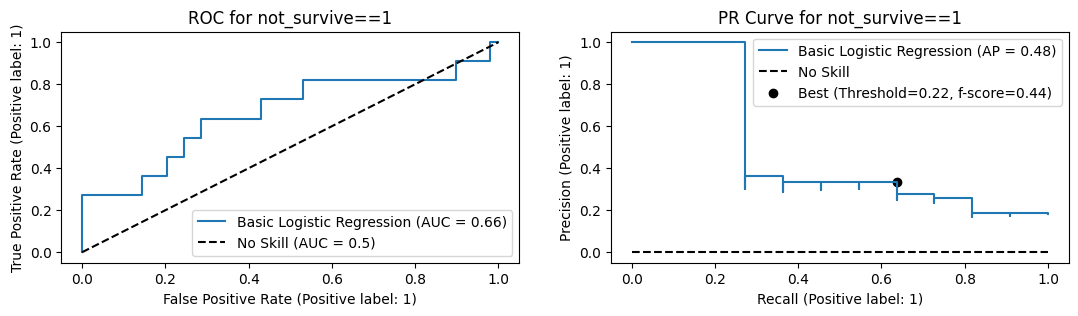

In [11]:
# plot ROC Curve. Class of interest is not_survive==1
class_id = np.flatnonzero(logistic_clf.classes_==1)[0]
# Plot the Metric curves
hp.plot_ROC_PR(y_test, prob_scores_test[:, class_id],\
     model_name= 'Basic Logistic Regression', label_to_plot="not_survive==1")

From the ROC AUC we observe that the basic logistic regression performs better than random guessing. 

In general for imbalanced datasets where the positive label is under-represented, examining only ROC may be misleading because the large number of negative class outcomes can obscure the increasing number of false positives as the threshold falls. [This article](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/#:~:text=The%20main%20reason%20for%20this%20optimistic%20picture%20is%20because%20of%20the%20use%20of%20true%20negatives%20in%20the%20False%20Positive%20Rate%20in%20the%20ROC%20Curve%20and%20the%20careful%20avoidance%20of%20this%20rate%20in%20the%20Precision%2DRecall%20curve.) provides an excellent example. 

The Precision-Recall curve provides a more robust assessment since Precision does not use the absolute number of negative labels in the data. The large number of false positives mentioned previously would be reflected in a poor precision score. 

In the context of our problem this metric is also useful. If patients predicted to not survive are given special attention upon arrival to the ICU, our predictions cannot include too many patients who would have otherwise survived anyway as it would be a poor use of resources. 

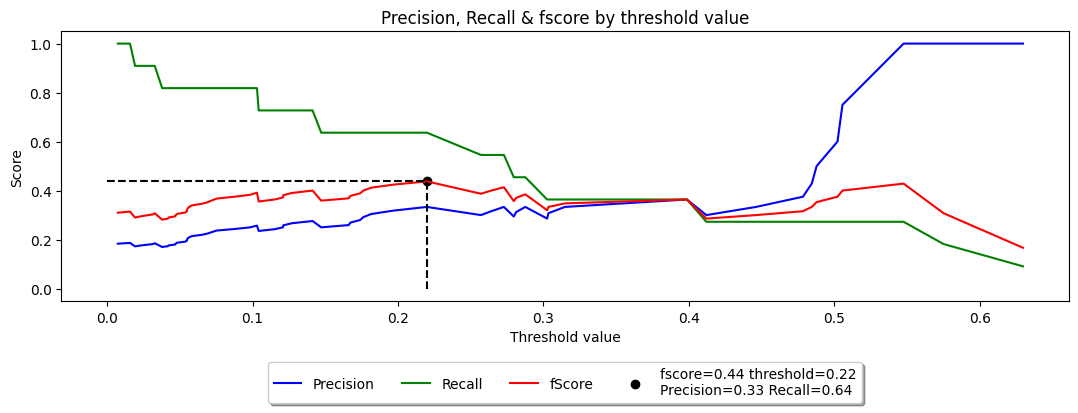

In [12]:
best_combi=hp.plot_precision_recall_vs_threshold(y_test, prob_scores_test[:, class_id])

From the graph we observe that the best f-score possible is 0.44, at a threshold value of 0.22. Let's see how this changes the original classification report. 

In [13]:
classification_report_collection['basic_logreg_tuned_threshold'] = classification_report(y_test, prob_scores_test[:, 1] >=best_combi[0][0], target_names=target_names, output_dict=True)
print(classification_report(y_test, prob_scores_test[:, 1] >=best_combi[0][0], target_names=target_names))

                 precision    recall  f1-score   support

       survived       0.90      0.71      0.80        49
did not survive       0.33      0.64      0.44        11

       accuracy                           0.70        60
      macro avg       0.62      0.68      0.62        60
   weighted avg       0.79      0.70      0.73        60



Compared with the original : 

In [14]:
hp.tablulate_confusion_matrix(classification_report_collection)

precision  recall  f1-score  \
Model                                                                         
basic_logreg_default_threshold survived              0.85    0.96      0.90   
                               did not survive       0.60    0.27      0.37   
                               accuracy               NaN     NaN      0.83   
basic_logreg_tuned_threshold   survived              0.90    0.71      0.80   
                               did not survive       0.33    0.64      0.44   
                               accuracy               NaN     NaN      0.70   

                                                support  
Model                                                    
basic_logreg_default_threshold survived              49  
                               did not survive       11  
                               accuracy              60  
basic_logreg_tuned_threshold   survived              49  
                               did not survive       11  
                               accuracy              60

Compared with the original threshold value, this new threshold value places a greater emphasis on recall than precision for the patients who do not survive. We also note that the f1 score of the _survived_ class also improved. 

## Logistic Regression Gridsearch

We now explore using regularization techniques to see if it improves model performance. 

In [15]:
param_grid = [
    {#  Penalty types to trial
     'penalty' : ['l1', 'l2', 'elasticnet'],
     'class_weight' : ['balanced'],
    # Penalty values
    'C' : np.linspace(0, 10000, 100), 
    'solver' : ['liblinear']
    }]

In [16]:
# Perform Gridsearch
log_gs_clf = GridSearchCV(estimator=LogisticRegression(random_state=0), param_grid=param_grid, verbose=False,\
                           n_jobs=1, cv = 5, scoring='precision')
warnings.filterwarnings("ignore")
log_gs_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0), n_jobs=1,
             param_grid=[{'C': array([    0.        ,   101.01010101,   202.02020202,   303.03030303,
         404.04040404,   505.05050505,   606.06060606,   707.07070707,
         808.08080808,   909.09090909,  1010.1010101 ,  1111.11111111,
        1212.12121212,  1313.13131313,  1414.14141414,  1515.15151515,
        1616.16161616,  1717.17171717,  1818.18181818,  1919.1919...
        8080.80808081,  8181.81818182,  8282.82828283,  8383.83838384,
        8484.84848485,  8585.85858586,  8686.86868687,  8787.87878788,
        8888.88888889,  8989.8989899 ,  9090.90909091,  9191.91919192,
        9292.92929293,  9393.93939394,  9494.94949495,  9595.95959596,
        9696.96969697,  9797.97979798,  9898.98989899, 10000.        ]),
                          'class_weight': ['balanced'],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['liblinear']}],
             scoring='precision', verbose=False)

In [17]:
# Observe the best params
log_gs_clf.best_params_

{'C': 101.01010101010101,
 'class_weight': 'balanced',
 'penalty': 'l1',
 'solver': 'liblinear'}

The returned logistic regression model with the best performance based on 5-fold cross validation is a l1-regularized logistic regression with balanced class weights .

In [18]:
# fit this set of params to the full training set
log_clg_bp = LogisticRegression(random_state=0, **log_gs_clf.best_params_)
log_clg_bp.fit(X_train, y_train)

LogisticRegression(C=101.01010101010101, class_weight='balanced', penalty='l1',
                   random_state=0, solver='liblinear')

In [19]:
# Make prediction on test data
prob_scores_test = log_clg_bp.predict_proba(X_test)
# Predicted class based on 0.5
y_pred = logistic_clf.predict(X_test)

### Performance Metrics

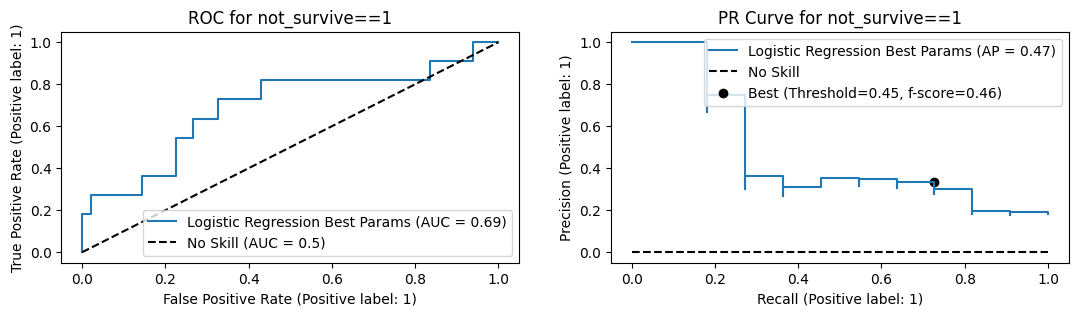

In [20]:
# plot ROC Curve. Class of interest is not_survive==1
class_id = np.flatnonzero(log_clg_bp.classes_==1)[0]
# Plot the Metric curves
hp.plot_ROC_PR(y_test, prob_scores_test[:, class_id],\
     model_name= 'Logistic Regression Best Params', label_to_plot="not_survive==1")

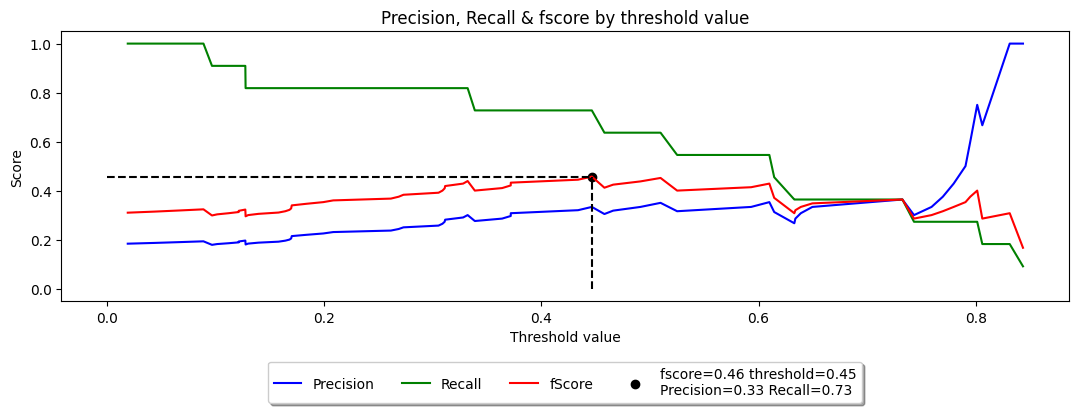

In [21]:
best_combi=hp.plot_precision_recall_vs_threshold(y_test, prob_scores_test[:, class_id])

In [22]:
classification_report_collection['regularized_logreg_tuned_threshold'] = classification_report(y_test, prob_scores_test[:, 1] >=best_combi[0][0], target_names=target_names, output_dict=True)
print(classification_report(y_test, prob_scores_test[:, 1] >=best_combi[0][0], target_names=target_names))

                 precision    recall  f1-score   support

       survived       0.92      0.67      0.78        49
did not survive       0.33      0.73      0.46        11

       accuracy                           0.68        60
      macro avg       0.62      0.70      0.62        60
   weighted avg       0.81      0.68      0.72        60



In [23]:
hp.tablulate_confusion_matrix(classification_report_collection, exclude_models=['default_threshold'])

precision  recall  \
Model                                                                   
basic_logreg_tuned_threshold       survived              0.90    0.71   
                                   did not survive       0.33    0.64   
                                   accuracy               NaN     NaN   
regularized_logreg_tuned_threshold survived              0.92    0.67   
                                   did not survive       0.33    0.73   
                                   accuracy               NaN     NaN   

                                                    f1-score  support  
Model                                                                  
basic_logreg_tuned_threshold       survived             0.80       49  
                                   did not survive      0.44       11  
                                   accuracy             0.70       60  
regularized_logreg_tuned_threshold survived             0.78       49  
                                   did not survive      0.46       11  
                                   accuracy             0.68       60

Compared to the [basic logistic regression](###-Performance-Metrics), we have managed to improve the recall of the patients who did not survive from 0.64 to 0.73, with no reduction in precision for this target class. 

The tradeoff is a reduction in Recall in the _survived_ label. 

# Decision Tree

Next we model the problem using a Decision tree, a decision tree classifier to be specific. This is a classic machine learning method that recursively splits the training data based on feature boundaries, splitting based on which features best separate the data into target groups. 

Decision trees are very easily overfitted since they will continue to split the training data unless stopping rules are specified. The best stopping criteria can be tricky to determine. 

We can use a gridsearch to obtain a decent estimate for the stopping parameters

## Model fitting

In [24]:
np.arange(0, 101, 5)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

In [25]:
tree_param_grid = [{
    'criterion' : ['entropy'],
    'max_depth':np.arange(0, 101, 5),
    'min_samples_leaf' : np.arange(1, 11)
}]

In [26]:
# Perform Gridsearch
dt_gs_clf = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), param_grid=tree_param_grid, verbose=False,\
                           n_jobs=1, cv = 5, scoring='precision')
dt_gs_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=1,
             param_grid=[{'criterion': ['entropy'],
                          'max_depth': array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100]),
                          'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}],
             scoring='precision', verbose=False)

In [27]:
# Fit to whole training set
dt_clf = DecisionTreeClassifier(random_state=0, **dt_gs_clf.best_params_)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=7,
                       random_state=0)

## Performance Metrics

In [28]:
# Probability scores for test data
prob_scores_test = dt_clf.predict_proba(X_test)

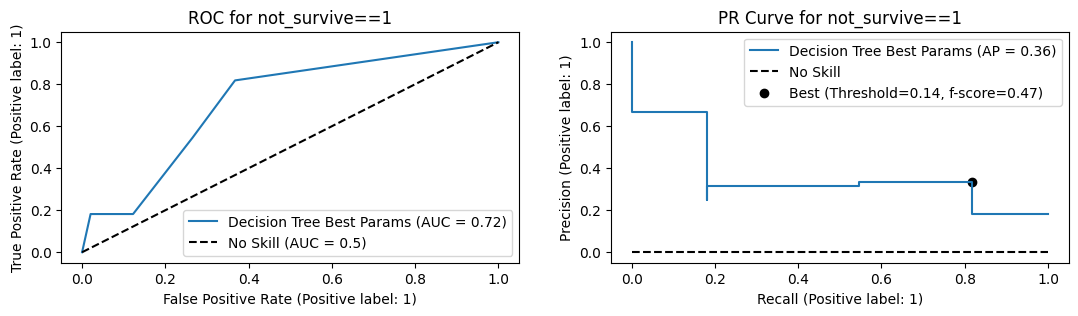

In [29]:
# plot ROC Curve. Class of interest is not_survive==1
class_id = np.flatnonzero(dt_clf.classes_==1)[0]
# Plot the Metric curves
hp.plot_ROC_PR(y_test, prob_scores_test[:, class_id],\
     model_name= 'Decision Tree Best Params', label_to_plot="not_survive==1")

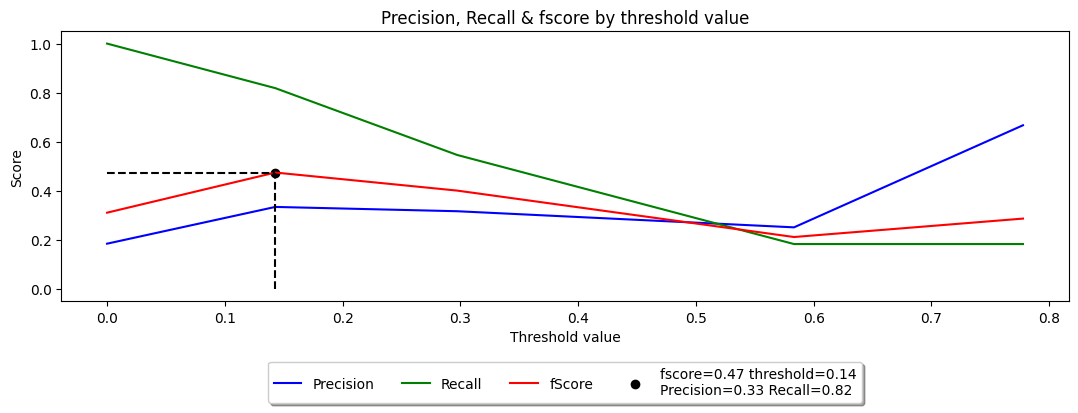

In [30]:
best_combi=hp.plot_precision_recall_vs_threshold(y_test, prob_scores_test[:, class_id])

In [31]:
classification_report_collection['decisiontree_tuned_threshold'] = classification_report(y_test, prob_scores_test[:, 1] >=best_combi[0][0], target_names=target_names, output_dict=True)
print(classification_report(y_test, prob_scores_test[:, 1] >=best_combi[0][0], target_names=target_names))

                 precision    recall  f1-score   support

       survived       0.94      0.63      0.76        49
did not survive       0.33      0.82      0.47        11

       accuracy                           0.67        60
      macro avg       0.64      0.73      0.61        60
   weighted avg       0.83      0.67      0.70        60



In [32]:
hp.tablulate_confusion_matrix(classification_report_collection=classification_report_collection, exclude_models=['default_threshold'])

precision  recall  \
Model                                                                   
basic_logreg_tuned_threshold       survived              0.90    0.71   
                                   did not survive       0.33    0.64   
                                   accuracy               NaN     NaN   
regularized_logreg_tuned_threshold survived              0.92    0.67   
                                   did not survive       0.33    0.73   
                                   accuracy               NaN     NaN   
decisiontree_tuned_threshold       survived              0.94    0.63   
                                   did not survive       0.33    0.82   
                                   accuracy               NaN     NaN   

                                                    f1-score  support  
Model                                                                  
basic_logreg_tuned_threshold       survived             0.80       49  
                                   did not survive      0.44       11  
                                   accuracy             0.70       60  
regularized_logreg_tuned_threshold survived             0.78       49  
                                   did not survive      0.46       11  
                                   accuracy             0.68       60  
decisiontree_tuned_threshold       survived             0.76       49  
                                   did not survive      0.47       11  
                                   accuracy             0.67       60

Observing the classification report at the tuned threshold score of 0.14, we can see that the recall for patients who do not survive has increased again from 0.73 to 0.82. Our model is getting better at correectly identifying patients who do not survive. 

The precision however did not improve for patients who did not survive, and the overall accuracy of this model compared to the regularized logistic regression with tuned threshold is very slightly smaller. 

## Decision Tree Explainability

Decision trees are easy to interperet. For this decision tree we have opted to use __entropy__ as our splitting criterion. __entropy__ is a measure of impurity within the node. Nodes with datapoints all belong to the same target group will be totally pure with __entropy==0__ and vice versa. 

The root node splits based on the feature partition that maximizes __information gain__, which is a measure of the difference in entropy between the parent node and the average entropy of the child nodes. 

Heuristically this simply refers to the feature boundary that is most able to cleanly split the data into patients who survived vs those that did not. This splitting takes place at each subsequent node until the tree hits the stopping criterion. 

`scikit-learn` allows us to easily visualize the decision tree obtained after fitting on the training set

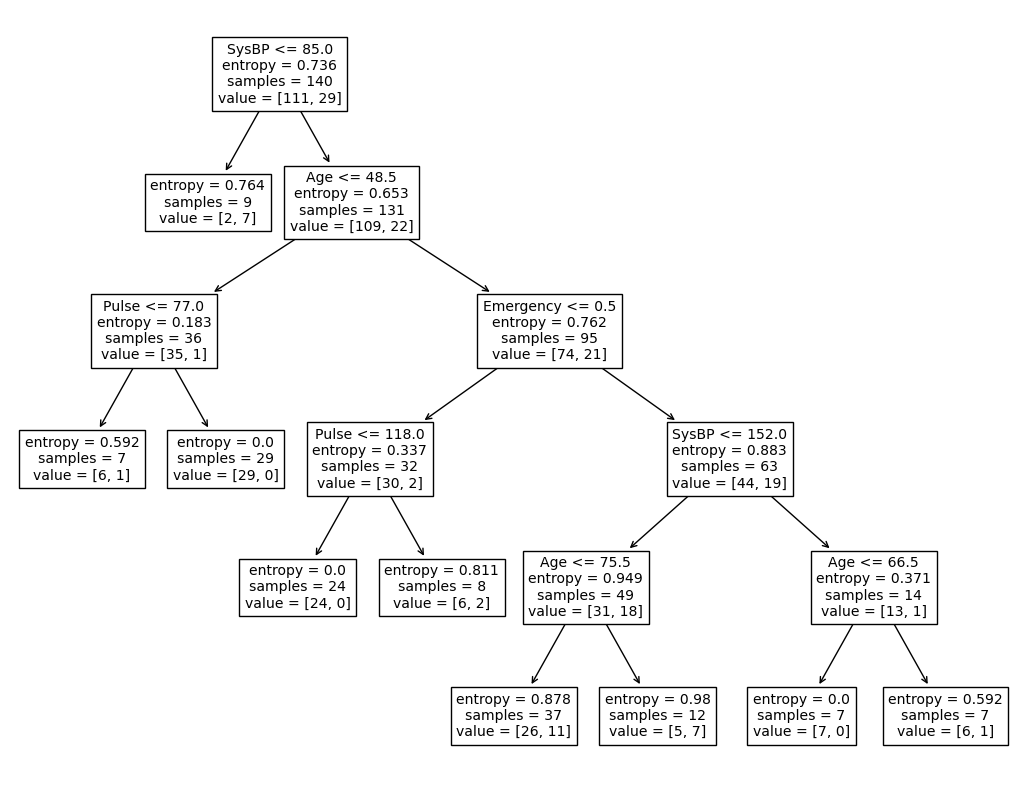

In [33]:
fig, ax = plt.subplots(figsize = (13, 10))
tree.plot_tree(dt_clf, feature_names=dt_clf.feature_names_in_, ax = ax)
plt.show()

`SysBp<85` was the most informative partition, functioning as the root node of the decision tree. 

For any new datapoint, we can trace its path through the decision tree to obtain the final predicted probability score (and class). The probability score is obtained based on the fraction of samples of the same class in the leaf node. 

We observe from the tree that the class label of interest (`not_survive==1`) is always the minority class in each leaf node, sometimes not appearing at all. This means that the probability score for `not_survive==1` of any new observation fed to this decision tree will likely be low, which explains why the tuned threshold value to obtain the max f1-score mentioned above is 0.14

# Random Forest

A random forest is an ensemble learning method which utilises multiple smaller decision trees to make predictions. Instead of one single decision tree, multiple small trees are used instead with each small tree only being able to split on a subset of all possible features. 

A key difference between a Random Forest model and a singular decision tree is that the former assigns high importance to a fixed set of features to predict the target class(the root node split for example), while the latter takes the majority vote of mulitple smaller trees with limited features instead. This makes the random forest less prone to overfitting and more robust to noise. 

## Model Fitting

Once again we can do a gridsearch to determine the best set of parameters for the random forest model. 

Since the dataset is small with a small number of total features, it is prudent to limit the minimum samples each leaf node must contain to a small number. This logic also applies to the number of estimators in the random forest. 

In [34]:
# 
rf_gridsearch_params = [{
    'criterion' : ['entropy']
    , 'class_weight' : ['balanced']
    , 'bootstrap':[True]
    , 'max_depth' : np.arange(1, 11, 2)
    , 'min_samples_leaf': np.arange(1,5)
    , 'n_estimators' : np.arange(5, 20, 5)
}]

In [35]:
# Perform Gridsearch
np.random.seed(41)
random.seed(41)
rf_gs_clf = GridSearchCV(estimator=RandomForestClassifier(random_state=0), param_grid=rf_gridsearch_params, verbose=1,\
                           n_jobs=-1, cv = 5, scoring=None)
rf_gs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid=[{'bootstrap': [True], 'class_weight': ['balanced'],
                          'criterion': ['entropy'],
                          'max_depth': array([1, 3, 5, 7, 9]),
                          'min_samples_leaf': array([1, 2, 3, 4]),
                          'n_estimators': array([ 5, 10, 15])}],
             verbose=1)

In [36]:
# Fit to whole training set
rf_clf = RandomForestClassifier(random_state=0, **rf_gs_clf.best_params_)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, n_estimators=10, random_state=0)

The returned model is a random forest made up of 10 subtrees each at most 9 nodes deep,  wherein the class weights are balanced. 

## Performance Metrics

In [37]:
# Probability scores for test data
prob_scores_test = rf_clf.predict_proba(X_test)

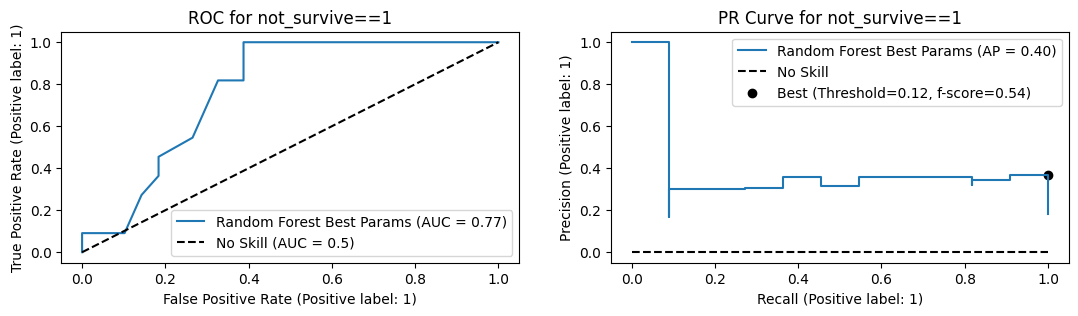

In [38]:
# plot ROC Curve. Class of interest is not_survive==1
class_id = np.flatnonzero(rf_clf.classes_==1)[0]
# Plot the Metric curves
hp.plot_ROC_PR(y_test, prob_scores_test[:, class_id],\
     model_name= 'Random Forest Best Params', label_to_plot="not_survive==1")

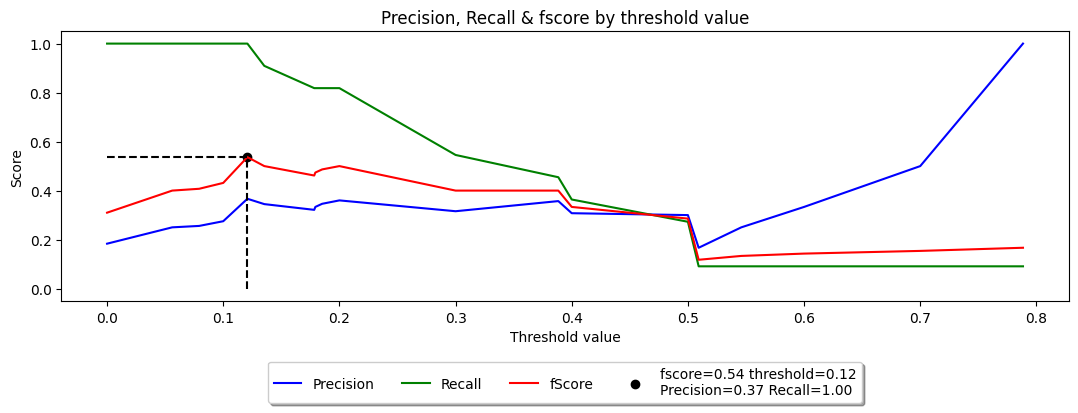

In [39]:
best_combi=hp.plot_precision_recall_vs_threshold(y_test, prob_scores_test[:, class_id])

In [40]:
classification_report_collection['randomforest_tuned_threshold'] = classification_report(y_test, prob_scores_test[:, 1] >=best_combi[0][0], target_names=target_names, output_dict=True)
print(classification_report(y_test, prob_scores_test[:, 1] >=best_combi[0][0], target_names=target_names))

                 precision    recall  f1-score   support

       survived       1.00      0.61      0.76        49
did not survive       0.37      1.00      0.54        11

       accuracy                           0.68        60
      macro avg       0.68      0.81      0.65        60
   weighted avg       0.88      0.68      0.72        60



In [41]:
hp.tablulate_confusion_matrix(classification_report_collection, exclude_models=['basic_logreg_default'])

precision  recall  \
Model                                                                   
basic_logreg_tuned_threshold       survived              0.90    0.71   
                                   did not survive       0.33    0.64   
                                   accuracy               NaN     NaN   
regularized_logreg_tuned_threshold survived              0.92    0.67   
                                   did not survive       0.33    0.73   
                                   accuracy               NaN     NaN   
decisiontree_tuned_threshold       survived              0.94    0.63   
                                   did not survive       0.33    0.82   
                                   accuracy               NaN     NaN   
randomforest_tuned_threshold       survived              1.00    0.61   
                                   did not survive       0.37    1.00   
                                   accuracy               NaN     NaN   

                                                    f1-score  support  
Model                                                                  
basic_logreg_tuned_threshold       survived             0.80       49  
                                   did not survive      0.44       11  
                                   accuracy             0.70       60  
regularized_logreg_tuned_threshold survived             0.78       49  
                                   did not survive      0.46       11  
                                   accuracy             0.68       60  
decisiontree_tuned_threshold       survived             0.76       49  
                                   did not survive      0.47       11  
                                   accuracy             0.67       60  
randomforest_tuned_threshold       survived             0.76       49  
                                   did not survive      0.54       11  
                                   accuracy             0.68       60

As expected, this model is the best so far in terms of identifying the target class of interest (`not_survive==1`). 

In this case the Recall on the test set is perfect, meaning that the model __correctly identifies all patients who do not survive__. The Precision for this model with respect to `not_survive==1` is also the highest among all other models. 

The precision for `not_survive==0` is also perfect, meaning that all patients predicted to survive do indeed survive. The tradeoff here is that the Recall for this label is lowered from previous models, meaning that not all patients who survive are correctly identified. 

Based on our framing of the problem with an emphasis on correctly spotting non-surviving patients, this tradeoff seems acceptable. 

## Model Exaplainability

A random forest model is not as easily interpretable as a decision tree model, since each subtree in the random forest is different. 

Scikit-learn implements feature importance for Random Forest by taking the weighted average of the the reduction in node impurity for a feature that the node splits on. [Reference here](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3#:~:text=Feature%20importance%20is%20calculated%20as,the%20more%20important%20the%20feature.)

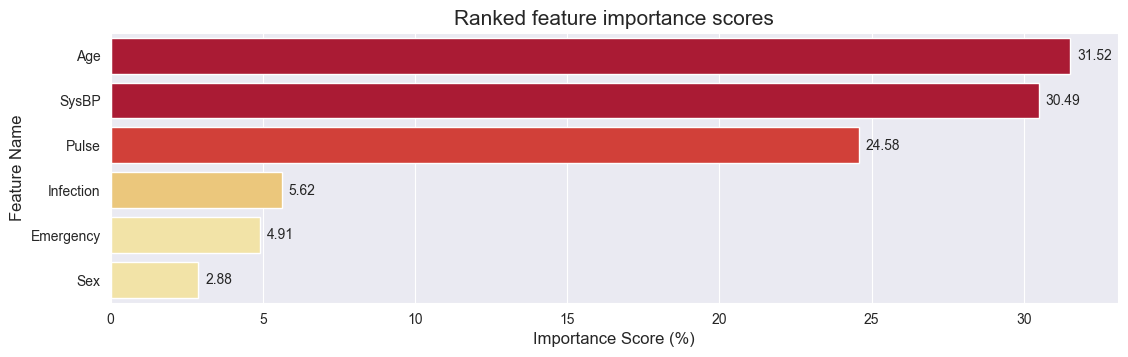

In [42]:
plot_df = pd.DataFrame({'feature' : rf_clf.feature_names_in_, 'importance score' : rf_clf.feature_importances_, }).sort_values('importance score', ascending=False)
plot_df['importance score'] = plot_df['importance score']*100

# Dataframe for plotting
sns.set_style("darkgrid")
# Set axes parameters
fig, ax = plt.subplots(figsize=[13,3.5])
sns.barplot(data=plot_df, y = 'feature', x = 'importance score', palette=hp.colors_from_values(plot_df['importance score'], 'YlOrRd'), ax = ax)

# Set the axis title and labels
ax.set_title(f'Ranked feature importance scores', fontsize = 15)
ax.set_xlabel('Importance Score (%)', fontsize = 12)
ax.set_ylabel('Feature Name', fontsize = 12)

# Annotate with exact importance scores
for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
                xytext=(5, 0), textcoords='offset points', ha="left", va="center")

Unlike the decision tree shown earlier, the random forest now has `Age` as the most important feature for predicting whether or not a patient survives. 

# Conclusion

We have discussed several machine learning methods to tackle the posed problem, examining how to tune the models and threshold values for a given set of probability scores to best classify each patient based on our priorities.

To recap, we let us view each the metrics for each class outcome (survived vs not survived) for each model 

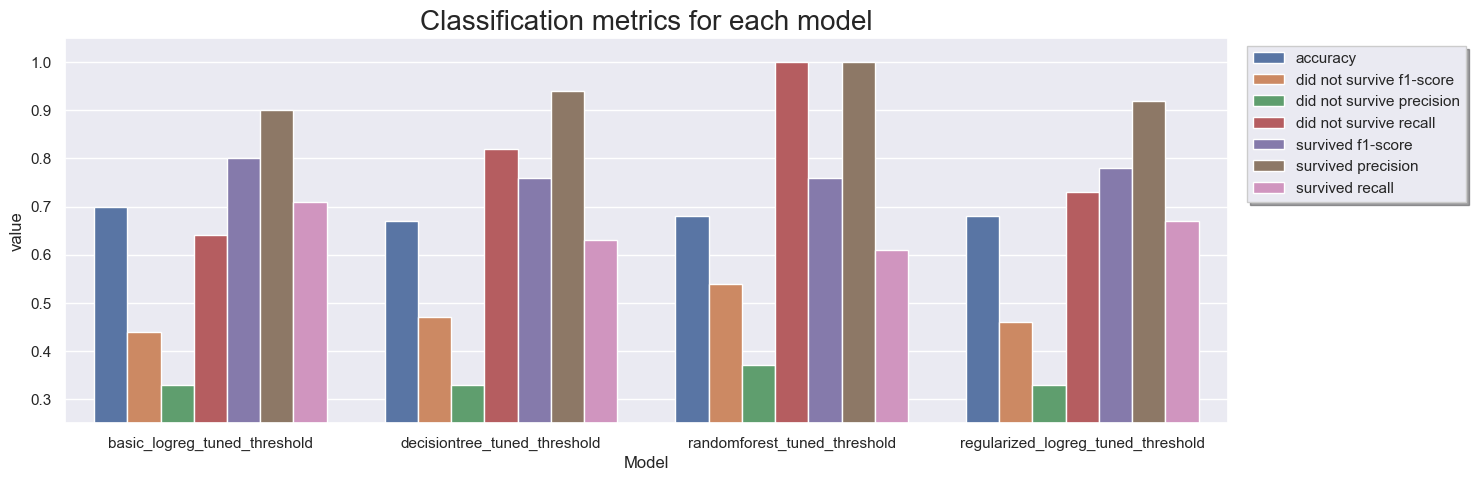

In [43]:
# Transform the combined classification reports for each model into a format suitable for plotting
tabulated_matrix = hp.tablulate_confusion_matrix(classification_report_collection, exclude_models=['basic_logreg_default'])
tabulated_matrix = tabulated_matrix.reset_index().drop('support', axis=1)
tabulated_matrix = tabulated_matrix.melt(id_vars = ['Model', 'level_1'], value_vars=tabulated_matrix.columns.difference(['Model', 'level_1'])).sort_values(['Model', 'level_1']).dropna()
tabulated_matrix['variable'] = tabulated_matrix.apply(lambda x : "accuracy" if x['level_1']=='accuracy' else x['level_1']+ " "+ x['variable'], axis=1)

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15,5))
# sns.barplot(data = pdf.loc[pdf['level_1']!='did not survive'], x = 'Model', y = 'value', hue='variable')
sns.barplot(data = tabulated_matrix, x = 'Model', y = 'value', hue='variable')
plt.legend(bbox_to_anchor=(1.01, 1),
          fancybox=False, shadow=True, ncol=1)
ax.set_title("Classification metrics for each model", fontsize=20)
ax.set_ylim((0.25, 1.05))
plt.show()

The Random Forest model is clearly the best model in terms of how well it classifies the test set. 

Its Precision and Recall for patients who did not survive is the greatest among all the models, meaning the random forest model best identifies all patients who will not survive, while minimizing wronlgy identifying patients who would survive as not surviving, hence minimizing misallocation of healthcare resources. 

Additionally, this does not come at the expense of accuracy in identifying patients who survive. The random forest model also beats all other models in terms of Precision for this class (`Survive==1`). 